<a href="https://colab.research.google.com/github/x1001000/books-chinese-networkx/blob/main/Co_occurrence_network.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# 下載博客來中文書各分類 csv 檔
! git clone https://github.com/x1001000/books-chinese-networkx

Cloning into 'books-chinese-networkx'...
remote: Enumerating objects: 9, done.
remote: Counting objects: 100% (9/9), done.
remote: Compressing objects: 100% (9/9), done.
remote: Total 974 (delta 3), reused 0 (delta 0), pack-reused 965
Receiving objects: 100% (974/974), 65.74 MiB | 22.19 MiB/s, done.
Resolving deltas: 100% (14/14), done.
Checking out files: 100% (966/966), done.


In [ ]:
# 解決 networkx 繪圖無法顯示中文問題
! wget https://github.com/googlefonts/noto-cjk/raw/master/NotoSansCJK-Regular.ttc
! cp NotoSansCJK-Regular.ttc /usr/local/lib/python3.6/dist-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf

--2020-11-08 04:59:20--  https://github.com/googlefonts/noto-cjk/raw/master/NotoSansCJK-Regular.ttc
Resolving github.com (github.com)... 140.82.112.4
Connecting to github.com (github.com)|140.82.112.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/googlefonts/noto-cjk/master/NotoSansCJK-Regular.ttc [following]
--2020-11-08 04:59:20--  https://raw.githubusercontent.com/googlefonts/noto-cjk/master/NotoSansCJK-Regular.ttc
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 19981104 (19M) [application/octet-stream]
Saving to: ‘NotoSansCJK-Regular.ttc’

NotoSansCJK-Regular 100%[===================>]  19.05M  28.5MB/s    in 0.7s    

2020-11-08 04:59:21 (28.5 MB/s) - ‘NotoSansCJK-Regular.ttc’ saved [19981104

In [ ]:
# 安裝 CKIP 套件
! pip install ckiptagger
# 下載 CKIP 模型（若當日下載次數太多可能會暫時無法下載）
from ckiptagger import data_utils
data_utils.download_data_gdown("./")

Downloading...
From: https://drive.google.com/uc?id=1efHsY16pxK0lBD2gYCgCTnv1Swstq771
To: /content/data.zip
1.88GB [00:11, 170MB/s]


In [ ]:
# 匯入斷詞、詞性標記、命名實體識別的三個工具
from ckiptagger import WS, POS, NER
ws = WS("./data")
pos = POS("./data")
ner = NER("./data")

In [ ]:
# 匯入所需的 Python 套件
import re
import itertools
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
from scipy.spatial import distance
import networkx as nx

In [ ]:
#@title 輸入
分類細項 = "文學小說 > 翻譯文學 > 日本文學" #@param {type:"string"}
分類細項 = 分類細項.replace(' ', '')
分類細項 = 分類細項.replace('>', '_')
出版年段 = "2020 ~ 2020" #@param {type:"string"}
出版年段 = 出版年段.replace(' ', '')
year_fr = int(出版年段[:4])
year_to = int(出版年段[-4:])
字詞出現次數大於 =  5#@param {type:"integer"}

In [ ]:
books = pd.read_csv(f'books-chinese-networkx/博客來-中文書_{分類細項}.csv')
books['出版年'] = pd.Series(int(date[:4]) for date in books['出版日期'])
books[(year_fr <= books['出版年']) & (books['出版年'] <= year_to)][['書名', '出版年']]

,書名,出版年
0,﹝新譯﹞宮本百合子的自由之心：收錄〈乳房〉、〈人類的婚姻〉等各種勇於做自己的冒險,2020
1,Days of My Past：512首詩，重返金子美鈴的純真年代【全詩集線裝手札】,2020
2,金色夜叉(三島由紀夫讚譽劃時代之作‧十九世紀末日本最暢銷「國民小說」‧全新中譯本),2020
3,Days of My Past：512首詩，重返金子美鈴的純真年代【全詩集線裝手札】(紀念鉛...,2020
4,那一天，我遇見可以實現願望的神明大人,2020
...,...,...
225,蹺蹺板怪物,2020
226,地下街的雨,2020
227,半邊藍天1,2020
228,金子美鈴詩選,2020


In [ ]:
# 銷售用詞及其括號
tags_to_remove = [
    r'\(.+版\)',
    r'（.+版）',
    r'﹝.+版﹞',
    r'【.+版】',
    r'〈.+版〉',
    r'《.+版》',

    r'\(全.+冊\)',
    r'（全.+冊）',
    r'﹝全.+冊﹞',
    r'【全.+冊】',
    r'〈全.+冊〉',
    r'《全.+冊》',

    r'\([上下]冊?\)',
    r'（[上下]冊?）',
    r'﹝[上下]冊?﹞',
    r'【[上下]冊?】',
    r'〈[上下]冊?〉',
    r'《[上下]冊?》',

    r'\(.*(新譯|譯本|導讀|精裝|線裝|扉頁|套組|套書|書衣|書票|附贈|贈品|海報|分售).*\)',
    r'（.*(新譯|譯本|導讀|精裝|線裝|扉頁|套組|套書|書衣|書票|附贈|贈品|海報|分售).*）',
    r'﹝.*(新譯|譯本|導讀|精裝|線裝|扉頁|套組|套書|書衣|書票|附贈|贈品|海報|分售).*﹞',
    r'【.*(新譯|譯本|導讀|精裝|線裝|扉頁|套組|套書|書衣|書票|附贈|贈品|海報|分售).*】',
    r'〈.*(新譯|譯本|導讀|精裝|線裝|扉頁|套組|套書|書衣|書票|附贈|贈品|海報|分售).*〉',
    r'《.*(新譯|譯本|導讀|精裝|線裝|扉頁|套組|套書|書衣|書票|附贈|贈品|海報|分售).*》',    ]

In [ ]:
# 去除銷售用詞及其括號，再刪除重複書名
titles = []
removed = []
for title in books[(year_fr <= books['出版年']) & (books['出版年'] <= year_to)]['書名']:
    for tag in tags_to_remove:
        match = re.search(tag, title)
        if match:
            removed.append(title)
            title = title.replace(match.group(0), '')
    titles.append(title)
print('去除銷售用詞及其括號，再刪除重複書名')
print(f'前： {len(titles)} 本')
print(f'後： {len(set(titles))} 本')

去除銷售用詞及其括號，再刪除重複書名
前： 230 本
後： 217 本


In [ ]:
# 分析使用的詞類
pos_to_keep = [
    'A',
    'ADV',
    'N',
    'Nv',
    'Vi',
    'Vt',
    'FW',]

In [ ]:
# 詞類對應 http://ckipsvr.iis.sinica.edu.tw/cat.htm
table = '''
A	A
Caa	C
Cab	POST
Cba	POST
Cbb	C
D	ADV
DE	T
Da	ADV
Dfa	ADV
Dfb	ADV
Di	ASP
Dk	ADV
FW	FW
I	T
Na	N
Nb	N
Nc	N
Ncd	N
Nd	N
Nep	DET
Neqa	DET
Neqb	POST
Nes	DET
Neu	DET
Nf	M
Ng	POST
Nh	N
Nv	Nv
P	P
SHI	Vt
T	T
VA	Vi
VAC	Vt
VB	Vi
VC	Vt
VCL	Vt
VD	Vt
VE	Vt
VF	Vt
VG	Vt
VH	Vi
VHC	Vt
VI	Vi
VJ	Vt
VK	Vt
VL	Vt
V_2	Vt'''

pos_reduced = {}
for k_v in table.strip().split('\n'):
    k,v = k_v.split()
    pos_reduced[k] = v

In [ ]:
# CKIP斷詞，若非分析使用的詞類，則出現次數歸零，統計字詞出現次數
term_count = {}
ws_of_titles = ws(set(titles))
pos_of_titles = pos(ws_of_titles)
for ws_of_title, pos_of_title in zip(ws_of_titles, pos_of_titles):
    for w, p in zip(ws_of_title, pos_of_title):
        if f'{w}({p})' not in term_count:
            term_count[f'{w}({p})'] = 1
        else:
            term_count[f'{w}({p})'] += 1
for term in term_count:
    term_pos = re.search(r'\((.+)\)', term).group(1)
    if term_pos not in pos_reduced:
        term_count[term] = 0
    elif pos_reduced[term_pos] not in pos_to_keep:
        term_count[term] = 0
term_count_df = pd.DataFrame({'字詞': [term for term in term_count], '出現次數': [count for count in term_count.values()]})
term_count_df

,字詞,出現次數
0,線(Na),2
1,，(COMMACATEGORY),0
2,畫出(VC),1
3,的(DE),0
4,我(Nh),15
...,...,...
886,想想(VE),1
887,惡醫(Na),1
888,也(D),1
889,會(D),1


In [ ]:
## 統計
#term_count_df[['出現次數']].describe()

In [ ]:
df = term_count_df[term_count_df['出現次數'] > 字詞出現次數大於].sort_values(by='出現次數', ascending=False)
print(f'出現次數大於 {字詞出現次數大於} 的字詞有 {len(df)} 個')

出現次數大於 5 的字詞有 23 個


In [ ]:
fig = px.bar(df, color='出現次數', color_continuous_scale=px.colors.sequential.Viridis, x='字詞', y='出現次數')
fig.show()

In [ ]:
vocab    = dict(zip(df['字詞'], range(len(df))))
re_vocab = dict(zip(range(len(df)), df['字詞']))#list(df['字詞'])
assert len(df) == len(vocab) == len(re_vocab)

In [ ]:
combinations_titles = [list(itertools.combinations(title, 2)) for title in titles]
cooccurrence_matrix = np.zeros((len(df), len(df)))
for combinations_title in combinations_titles:
    for comb in combinations_title:
        if comb[0] in vocab and comb[1] in vocab:
            cooccurrence_matrix[vocab[comb[0]], vocab[comb[1]]] += 1
            cooccurrence_matrix[vocab[comb[1]], vocab[comb[0]]] += 1
for i in range(len(df)):
    cooccurrence_matrix[i, i] /= 2
#cooccurrence_matrix

In [ ]:
jaccard_matrix = 1 - distance.cdist(cooccurrence_matrix, cooccurrence_matrix, 'jaccard')
#jaccard_matrix

In [ ]:
pairs = []
for i in range(len(df)):
    for j in range(i+1, len(df)):
        jaccard = jaccard_matrix[i, j]
        if jaccard > 0:
            pairs.append([re_vocab[i], re_vocab[j], term_count[re_vocab[i]], term_count[re_vocab[j]], jaccard])
#len(pairs)

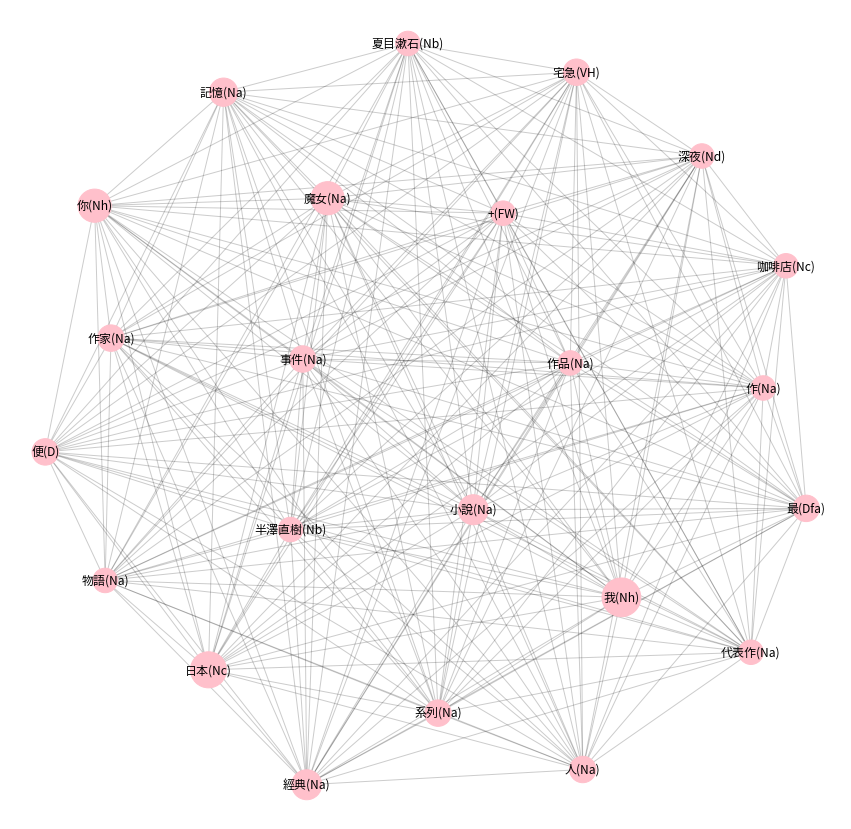

In [ ]:
G = nx.Graph()
G.nodes(data=True)

for pair in pairs:
    node_x, node_y, node_x_cnt, node_y_cnt, jaccard = pair#[0], pair[1], pair[2], pair[3], pair[4]
    if not G.has_node(node_x):
        G.add_node(node_x, count=node_x_cnt)
    if not G.has_node(node_y):
        G.add_node(node_y, count=node_y_cnt)
    if not G.has_edge(node_x, node_y):
        G.add_edge(node_x, node_y, weight=jaccard)
    #else:
    #    print(pair)
        
plt.figure(figsize=(15,15))
_pos = nx.spring_layout(G, k=None)

node_size = [d['count']*100 for (n,d) in G.nodes(data=True)]
nx.draw_networkx_nodes(G, _pos, node_color='pink', alpha=1.0, node_size=node_size)
nx.draw_networkx_labels(G, _pos)#, fontsize=14, font_family='Droid Sans Japanese')

edge_width = [d['weight']*1 for (u,v,d) in G.edges(data=True)]
nx.draw_networkx_edges(G, _pos, alpha=0.2, edge_color='black', width=edge_width)

plt.axis('off')
plt.show()